# DFT MD on disordered `HfNbTaZr` alloy

A disordered equiatomic `HfNbTaZr` crystal was generated in Vesta using atomic positions seeded randomly using `mcsqs`.

This notebook handles a few things:
1. Slab relaxation, if `RUN_RELAXATION=True`
2. MD run at configurable # time steps, dt, initial eV
3. Previewing system (`preview(...)`)

Use `ase gui <output_filename.out>` to view animated relax/MD output.

# Helpers

In [1]:
from ase import Atom, Atoms
from ase.calculators.espresso import Espresso
from ase.constraints import FixAtoms
from ase.io.cif import read_cif
from ase.io.espresso import read_espresso_out, write_espresso_in
from ase.io.vasp import read_vasp
from ase.visualize import view
from ase.visualize.plot import plot_atoms

from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime

from qe_utils import (velocity,
    import_vasp,
    output_to_atoms,
    relax,
    pin_bottom_layers,
    get_D_position,
    preview,
    md,
    sanitize)

In [2]:
# Numeric constants
# 1 picosecond = n Rydberg a.u.
PS_TO_AU = 1e-12 / (4.8378 * 1e-17)

# 1 femtosecond
FS_TO_AU = 1e-15 / (4.8378 * 1e-17)

In [3]:
#########################################################################
# RUN_RELAXATION
#    - True: run a relaxation step (can take several hours)
#    - False: don't run a relaxation step, use an existing relaxed crystal
# An existing relaxed crystal exists in relax_data/relax_Hf5Nb2Ta10Zr5.out
#########################################################################
RUN_RELAXATION = False

#########################################################################
# VACUUM
#    - Amount of vacuum, in Angstroms, to place on either side of the system
#########################################################################
VACUUM = 2.0

#########################################################################
# DEUTERIUM_MASS_AMU
#    - Deuterium mass in AMU
#########################################################################
DEUTERIUM_MASS_AMU = 2.014

#########################################################################
# INITIAL_DISTANCE_A
#    - Initial distance between D atom and surface of slab, in Angstroms
#########################################################################
INITIAL_DISTANCE_A = 1.0

#########################################################################
# AXIS
#    - One of { 'x', 'y', 'z' }: axis along which the D atom should travel
#########################################################################
AXIS = 'x'

#########################################################################
# N_STEPS
#    - Number of steps to run MD for
N_STEPS = 10

#########################################################################
# INITIAL_EV
#    - Initial eV to impart on D atom
#########################################################################
INITIAL_EV = 1000

#########################################################################
# DT
#    - dt, in AU
#########################################################################
DT = 0.2 * round(FS_TO_AU) # 0.2fs

INCIDENT_ANGLE_DEG = 45
POLAR_ANGLE_DEG = 45

## Add vacuum and a single `D` atom

Fix the crystal in place & add vacuum on either side. Then add an unconstrained `D` atom `INITIAL_DISTANCE_A` Angstroms away from the slab.

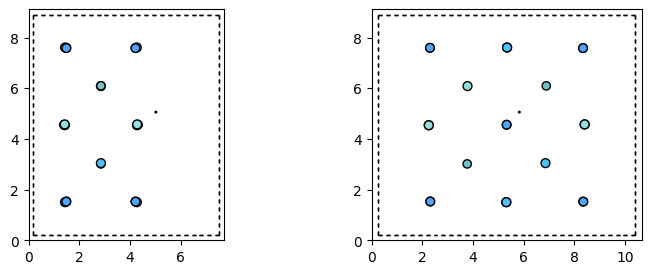

In [4]:
# Run relaxation, if needed
if RUN_RELAXATION:
    slab = import_vasp('input/HfNbTaZr_8.vasp', truncate=False)
    slab.center(vacuum=1)
    relax_output_filename = relax(slab)
    
# Create our slab
slab = output_to_atoms(relax_output_filename if RUN_RELAXATION else 'relax_data/relax_Hf5Nb2Ta10Zr5.out') # This slab is the result of relaxing a 22-atom crystal
atoms = deepcopy(slab)
atoms.center(vacuum=VACUUM, axis=2)
atoms = pin_bottom_layers(atoms, nlayers=1, axis=AXIS)

# Place the D atom in the center of the slab, `INITIAL_DISTANCE_A` Angstroms away
DEUTERIUM_XYZ = get_D_position(atoms, initial_distance_a=INITIAL_DISTANCE_A, axis=AXIS, normal_angle_deg=INCIDENT_ANGLE_DEG, polar_angle_deg=POLAR_ANGLE_DEG)
deuterium = Atom('H', mass=DEUTERIUM_MASS_AMU, position=DEUTERIUM_XYZ)
atoms.append(deuterium)

# Expand unit cell so that the D atom fits
existing_cell = atoms.get_cell()
atoms.set_cell(np.array([ # TODO this code is dogshit, clean it up
    existing_cell[0][0] + (2 * INITIAL_DISTANCE_A if AXIS == 'x' else 0),
    existing_cell[1][1] + (2 * INITIAL_DISTANCE_A if AXIS == 'y' else 0),
    existing_cell[2][2] + (2 * INITIAL_DISTANCE_A if AXIS == 'z' else 0)]
))

preview(atoms)

## Run MD

In [ ]:
output_filename = md(atoms, nsteps=N_STEPS, dt=DT, initial_eV=INITIAL_EV, incident_angle_deg=INCIDENT_ANGLE_DEG, polar_angle_deg=POLAR_ANGLE_DEG, ncores=12)

Writing D initial velocity 1000eV (0.14149136432947648 Hartree au)


In [ ]:
# We have to do this bit to get `ase` to be able to read the file in again
# TODO: file bugfix PR in ase
sanitize(output_filename)

From here, run `ase gui <output_filename>` to view the animation